# Alzheimer EDA


In [6]:
import zipfile,os
import shutil
from shutil import copyfile
from tqdm.notebook import tqdm as tq

import pandas as pd
import numpy as np
import random, re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from skimage import io, img_as_ubyte
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.preprocessing import image

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

## Data Preparation

### Data Loading

In [8]:
dataset_dir = '../data/combined_images'
os.listdir(dataset_dir)

['VeryMildDemented', 'NonDemented', 'MildDemented', 'ModerateDemented']

### Dataset Overview

In [9]:
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [10]:
def print_images_resolution(directory: str):
    unique_sizes = list()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.append(img.size)

        print('Pixel Size of 5 Samples')
        for size in unique_sizes[:5]:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [11]:
print_images_resolution(dataset_dir)

VeryMildDemented: 11200
Pixel Size of 5 Samples
- (176, 208)
- (200, 190)
- (180, 180)
- (200, 190)
- (180, 180)
---------------
NonDemented: 12800
Pixel Size of 5 Samples
- (176, 208)
- (200, 190)
- (180, 180)
- (200, 190)
- (180, 180)
---------------
MildDemented: 10000
Pixel Size of 5 Samples
- (176, 208)
- (200, 190)
- (180, 180)
- (200, 190)
- (180, 180)
---------------
ModerateDemented: 10000
Pixel Size of 5 Samples
- (176, 208)
- (200, 190)
- (180, 180)
- (200, 190)
- (180, 180)
---------------

Total: 44000


In [12]:
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

In [13]:
df.head()

,path,file_name,labels
0,../data/combined_images/VeryMildDemented/verym...,verymildDem1661.jpg,VeryMildDemented
1,../data/combined_images/VeryMildDemented/d9e0a...,d9e0a21f-636c-40c9-87ba-5da9748100c6.jpg,VeryMildDemented
2,../data/combined_images/VeryMildDemented/aeecb...,aeecb0bf-f945-40ef-90ad-587a65d2bf07.jpg,VeryMildDemented
3,../data/combined_images/VeryMildDemented/403a1...,403a1cec-e666-40f4-aa4e-181ebf0db599.jpg,VeryMildDemented
4,../data/combined_images/VeryMildDemented/af9e4...,af9e4ccb-ef3b-41da-8e96-82ecbe50874c.jpg,VeryMildDemented


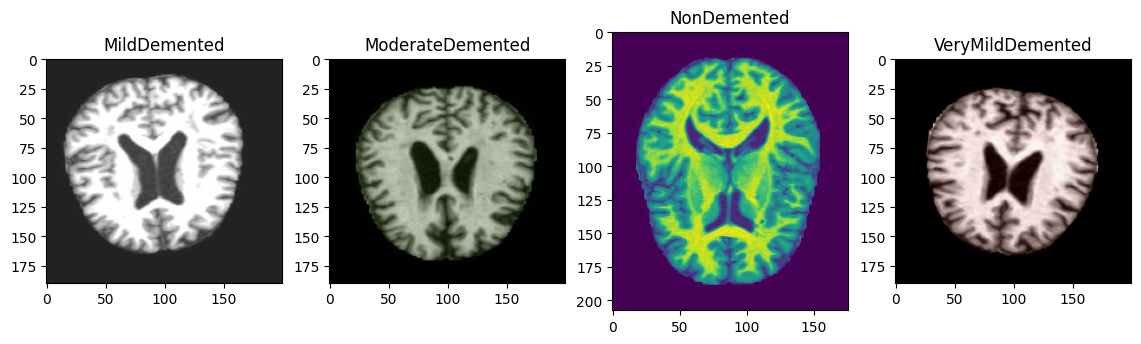

In [14]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(14, 10))

for i, class_name in enumerate(categories):
    class_dir = os.path.join(dataset_dir, class_name)
    image_path = os.path.join(class_dir, np.random.choice(os.listdir(class_dir)))  #Ambil gambar random
    # Load and display the image
    img = plt.imread(image_path)
    axs.flat[i].imshow(img)
    axs.flat[i].set_title(class_name)
    plt.subplots_adjust(top=1.2)  # Adjust the top margin to create space

plt.show()

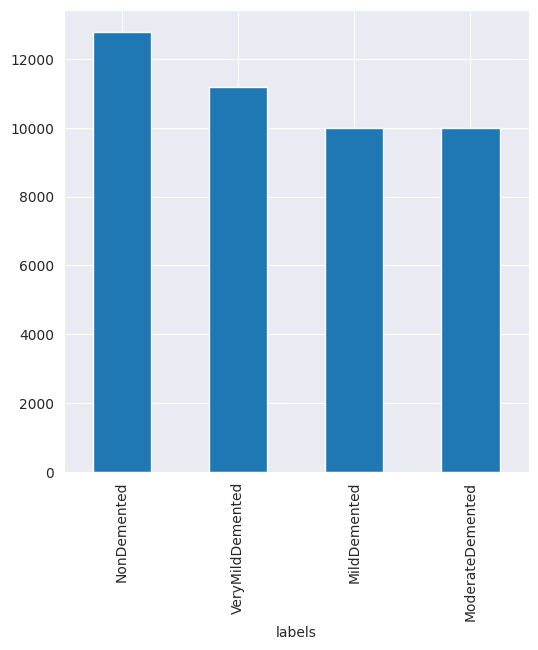

In [15]:
# Plot the distribution of imagesbar across the classes
Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data =df['labels'].value_counts().plot.bar()

In [16]:
df['labels'].value_counts()

labels
NonDemented         12800
VeryMildDemented    11200
MildDemented        10000
ModerateDemented    10000
Name: count, dtype: int64

Text(0, 0, 'Total:\n44000')

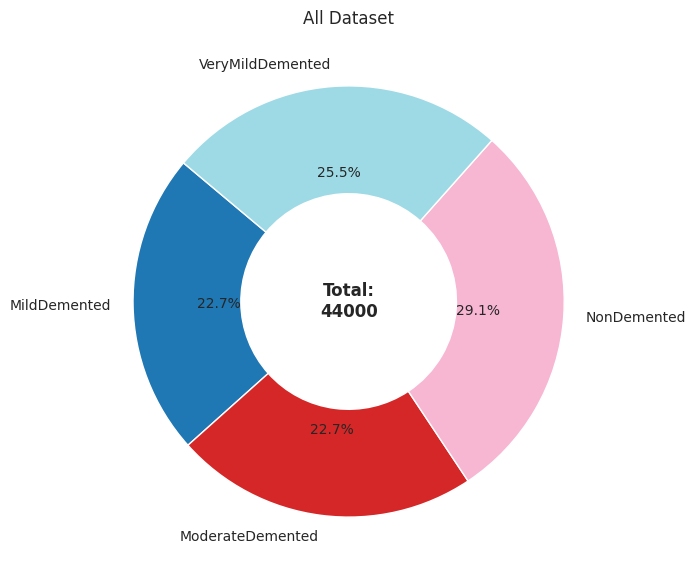

In [17]:
fig, axes = plt.subplots(1,1, figsize=(10, 7))
color = cm.get_cmap('tab20', len(categories))

axes.pie(df.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes.set_title("All Dataset")
axes.text(0, 0, f'Total:\n{df.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

**Filtering Dataframe**: 

karena dataset yang dimiliki memeliki data yang terlalu banyak yakni 44.000, sehingga dilakukan pengambilan sample yakni hanya 20.000 data masih kriteria penilaian biar full bintang hehe, dataframe dibagi untuk tiap label: **5000 NonDemented, 5000 VeryMildDemented, 5000 MildDemented, 5000 ModerateDemented**

In [18]:
sample_size = 5000

# Mengambil sample dari tiap label
filtered_df = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(n=sample_size, random_state=42))

# Reset index setelah sampling
filtered_df = filtered_df.reset_index(drop=True)

In [19]:
filtered_df.labels.value_counts()

labels
MildDemented        5000
ModerateDemented    5000
NonDemented         5000
VeryMildDemented    5000
Name: count, dtype: int64

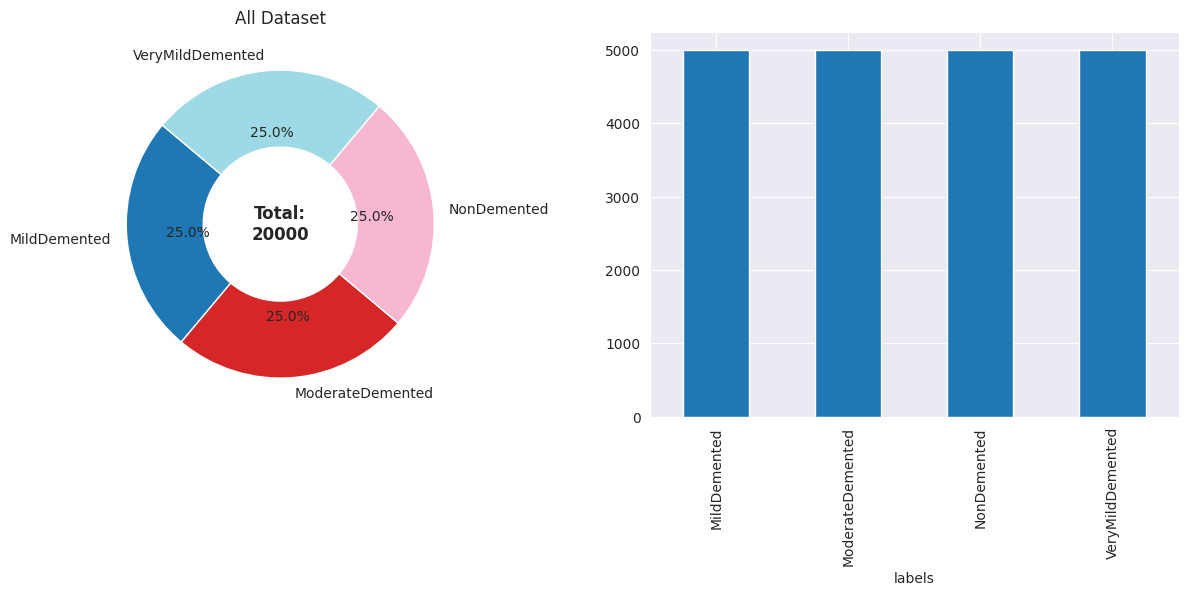

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
color = cm.get_cmap('tab20', len(categories))

axes[0].pie(filtered_df.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[0].set_title("All Dataset")
axes[0].text(0, 0, f'Total:\n{filtered_df.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[1] = filtered_df['labels'].value_counts().plot.bar()

### Data Preprocessing

#### Split Dataset

In [15]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= filtered_df['path']
y= filtered_df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})


set    labels          
test   MildDemented         995
       ModerateDemented    1024
       NonDemented         1004
       VeryMildDemented     977
train  MildDemented        4005
       ModerateDemented    3976
       NonDemented         3996
       VeryMildDemented    4023
dtype: int64 


Total size 20000
train size 16000
test size 4000



<Axes: >

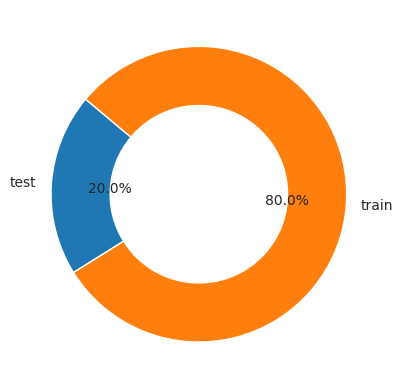

In [17]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')
print('Total size', len(df_all))
print('train size', len(df_tr))
print('test size', len(df_te))
print('===================================================== \n')
df_all.groupby('set').size().plot.pie(autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4})

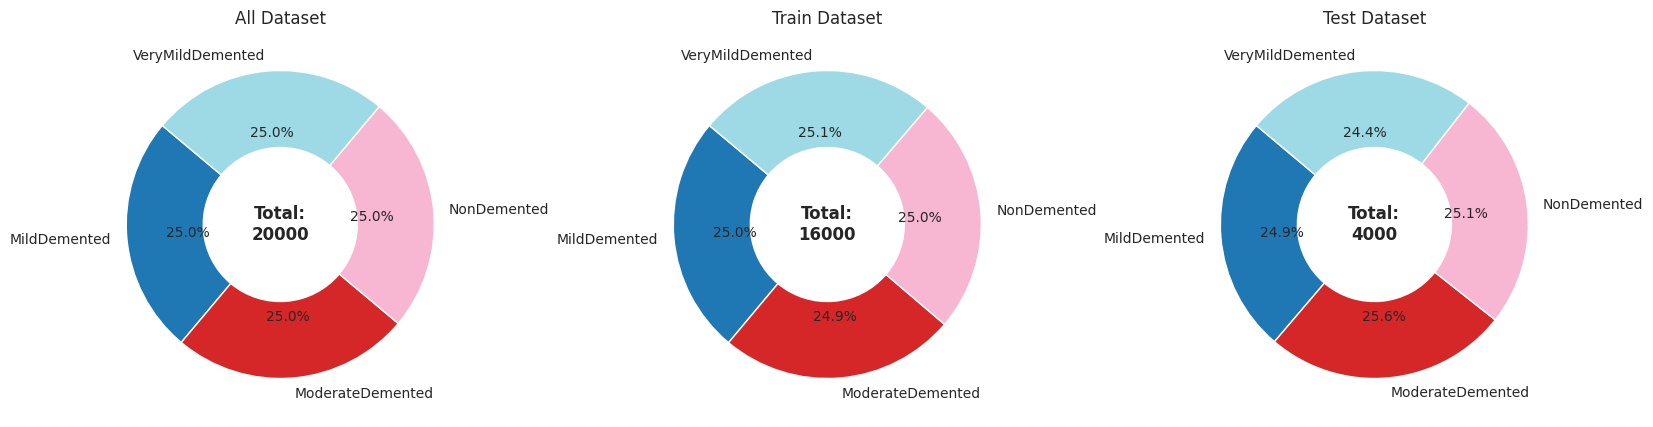

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
color = cm.get_cmap('tab20', len(categories))

axes[0].pie(df_all.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[0].set_title("All Dataset")
axes[0].text(0, 0, f'Total:\n{df_all.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[1].pie(df_tr.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[1].set_title("Train Dataset")
axes[1].text(0, 0, f'Total:\n{df_tr.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')

axes[2].pie(df_te.groupby('labels').size(), labels=categories ,autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.5}, colors=color(np.arange(len(categories))))
axes[2].set_title("Test Dataset")
axes[2].text(0, 0, f'Total:\n{df_te.shape[0]}', ha='center', va='center', fontsize=12, weight='bold')
plt.show()

**Menyimpan Data Splitting ke Directory**: agar mudah pindah pindah penyedia free gpu kak huhu

In [19]:
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/kaggle/working/Dataset_Final"

for index, row in tq(df_all.iterrows()):
    # Normalize file path
    file_path = os.path.normpath(row['path'])

    if not os.path.exists(file_path):
        file_path = os.path.normpath(os.path.join(clean_dataset_dir, row['labels'], row['image'].split('.')[0]))

    # Create destination directory if it doesn't exist
    destination_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Determine the destination file path
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(destination_dir, destination_file_name)

    # Copy the file if it doesn't already exist in the destination
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [20]:
new_dir = '/kaggle/working/Dataset_Final'
# Define training and test directories
TRAIN_DIR = '/kaggle/working/Dataset_Final/train'
TEST_DIR = '/kaggle/working/Dataset_Final/test'

print(os.listdir(new_dir))
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))

['test', 'train']
['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']


In [21]:
train_VeryMildDemented = os.path.join(TRAIN_DIR + '/VeryMildDemented')
train_NonDemented = os.path.join(TRAIN_DIR + '/NonDemented')
train_ModerateDemented = os.path.join(TRAIN_DIR + '/ModerateDemented')
train_MildDemented = os.path.join(TRAIN_DIR + '/MildDemented')

test_VeryMildDemented = os.path.join(TEST_DIR + '/VeryMildDemented')
test_NonDemented = os.path.join(TEST_DIR + '/NonDemented')
test_ModerateDemented = os.path.join(TEST_DIR + '/ModerateDemented')
test_MildDemented = os.path.join(TEST_DIR + '/MildDemented')

print("Total number of battery images in training set: ",len(os.listdir(train_VeryMildDemented)))
print("Total number of biological images in training set: ",len(os.listdir(train_NonDemented)))
print("Total number of cardboard images in training set: ",len(os.listdir(train_ModerateDemented)))
print("Total number of clothes images in training set: ",len(os.listdir(train_MildDemented)))
print("\n")
print("Total number of battery images in test set: ", len(os.listdir(test_VeryMildDemented)))
print("Total number of biological images in test set: ", len(os.listdir(test_NonDemented)))
print("Total number of cardboard images in test set: ", len(os.listdir(test_ModerateDemented)))
print("Total number of clothes images in test set: ", len(os.listdir(test_MildDemented)))

Total number of battery images in training set:  4023
Total number of biological images in training set:  3996
Total number of cardboard images in training set:  3976
Total number of clothes images in training set:  4005


Total number of battery images in test set:  977
Total number of biological images in test set:  1004
Total number of cardboard images in test set:  1024
Total number of clothes images in test set:  995


In [22]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle = False
)

Found 16000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [23]:
print("classes: ", train_generator.class_indices)

classes:  {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


## Modelling

In [24]:
input_shape = (224, 224, 3)

efficient_net_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
efficient_net_base.trainable = False

model1 = Sequential([
    Input(shape=input_shape),
    efficient_net_base,
    Conv2D(1024, (4, 4),padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

NameError: name 'EfficientNetB0' is not defined

In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
input_shape = (224, 224, 3)

mobile_netV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobile_netV2.trainable = False

model2 = Sequential([
    Input(shape=input_shape),
    mobile_netV2,
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Conv2D(1024, (4, 4),padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [ ]:
model2.summary()

In [ ]:
model2.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_base.trainable = False

model3 = Sequential([
    Input(shape=input_shape),
    vgg16_base,
    Conv2D(1024, (4, 4),padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [ ]:
model3.summary()

In [ ]:
model3.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

### Training Model

In [ ]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.5,
        min_lr=0.0000001
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='/kaggle/working/best_vgg16.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

In [ ]:
print("classes: ", train_generator.class_indices)

In [ ]:
count_MildDemented = len(os.listdir(train_MildDemented))
count_ModerateDemented = len(os.listdir(train_ModerateDemented))
count_NonDemented = len(os.listdir(train_NonDemented))
count_VeryMildDemented = len(os.listdir(train_VeryMildDemented))


total_images = (count_MildDemented + count_ModerateDemented + count_NonDemented +
                count_VeryMildDemented)

weight_MildDemented = (1 / count_MildDemented) * total_images / 4.0
weight_ModerateDemented = (1 / count_ModerateDemented) * total_images / 4.0
weight_NonDemented = (1 / count_NonDemented) * total_images / 4.0
weight_VeryMildDemented = (1 / count_VeryMildDemented) * total_images / 4.0

class_weights = {
    0: weight_MildDemented,
    1: weight_ModerateDemented,
    2: weight_NonDemented,
    3: weight_VeryMildDemented,
    }

print("Class Weights:", class_weights)

In [ ]:
BATCH_SIZE = 64

history1 = model1.fit(train_generator,
                      epochs = 20,
                      batch_size = BATCH_SIZE,
                      validation_data=test_generator,
                      class_weight = class_weights,
                      callbacks=[callbacks])

In [ ]:
BATCH_SIZE = 32

history2 = model2.fit(train_generator,
                      epochs = 20,
                      batch_size = BATCH_SIZE,
                      validation_data=test_generator,
                      class_weight = class_weights,
                      callbacks=[callbacks])

In [ ]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
history3 = model3.fit(train_generator,
                      epochs = 20,
                      validation_data=test_generator,
                      callbacks=[callbacks])

## Evaluasi dan Visualisasi

In [ ]:
# Plot training and validation accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
IMG_SIZE = (224, 224)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle = False
)

In [ ]:
predictions = model3.predict(val_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(val_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Konversi Model

### Saved Model

In [ ]:
# Save model as SavedModel
export_dir = '/kaggle/working/Model3/saved_model/'
tf.saved_model.save(model3, export_dir)

### TF-Lite

In [ ]:
import pathlib

In [ ]:
# Load the model from the .keras file
model_path = "/kaggle/working/best_vgg16.keras"
model = tf.keras.models.load_model(model_path)
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)  
tflite_model = converter.convert()

# Save the converted TFLite model
tflite_model_file = pathlib.Path("/kaggle/working/best_model_vgg16.tflite")
tflite_model_file.write_bytes(tflite_model)

### TFJS

In [ ]:
!pip uninstall tensorflowjs==4.21.0

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_vgg16.keras")  # Load .keras model
model.save("best_vgg16.h5")  # Save as .h5

In [ ]:
tfjs_model_dir = '/kaggle/working/tfjs_model/'

!tensorflowjs_converter --input_format=keras best_vgg16.h5 {tfjs_model_dir}

In [ ]:
print(tf.__version__)

In [ ]:
!pip install tensorflow==2.14.0

In [ ]:
print(tf.__version__)

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --saved_model_tags=serve \
    /kaggle/working/Model3/saved_model \
    /kaggle/working/tfjs_model2/

## Inference

In [ ]:
def predict_images_in_folder(folder_path):
    model_path = '/kaggle/working/Model3/saved_model'
    
    # Check if model is loaded correctly
    model = tf.saved_model.load(model_path)
    print("Model loaded successfully.")

    # Check model signatures
    print(model.signatures.keys())
    infer = model.signatures['serving_default']
    print("Inference signature loaded.")

    labels = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

    images = []
    titles = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            image_array = np.array(image).astype(np.float32) / 255.0
            image_array = np.expand_dims(image_array, axis=0)

            # Run the model inference and check available keys
            predictions = infer(tf.convert_to_tensor(image_array, dtype=tf.float32))
            print("Prediction keys:", predictions.keys())

            prediction_output = predictions['output_0']  # Replace with the correct key
            predicted_index = np.argmax(prediction_output.numpy(), axis=1)[0]
            predicted_probability = np.max(prediction_output.numpy()) * 100
            predicted_label = labels[predicted_index]

            images.append(image)
            titles.append(f"{predicted_label} ({predicted_probability:.2f}%)")

    num_images = len(images)
    plt.figure(figsize=(27, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

    plt.suptitle("Prediction", y=0.75)
    plt.subplots_adjust(top=0.75)
    plt.show()

In [ ]:
TestPredictImage_path = '/kaggle/input/predict-alzheimer-test/test-predict-image'
predict_images_in_folder(TestPredictImage_path)

## Download Output

In [ ]:
!zip -r model3.zip /kaggle/working/Model3

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('model3.zip')

In [ ]:
FileLink('best_vgg16.h5')

In [ ]:
!zip -r tfjs_model2.zip /kaggle/working/tfjs_model2

In [ ]:
!zip -r tfjs_model.zip /kaggle/working/tfjs_model

In [ ]:
FileLink('tfjs_model.zip')

In [ ]:
FileLink('dataset_final.zip')

In [ ]:
FileLink('best_vgg16.keras')

In [ ]:
FileLink('tfjs_model2.zip')

In [ ]:
FileLink('best_model_vgg16.tflite')

In [ ]:
pip freeze > requirements.txt

In [ ]:
FileLink('requirements.txt')